# LIS 590 Term Project Component 1

#### First Edit:  03/29/2017
#### Last Edit: 04/05/2017

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import time
from datetime import datetime
import ipywidgets

## Read CUMTD data as pandas dataframes

--- 
This part of codes deals with reading in original data.

In [2]:
### use command line to
### retrieve a list of all CUMTD txt files and 
### save the list as a text file named cumtd_allfiles.txt at the directory "~/work"

### if open this notebook on server, use this line:
#!ls ~/work/data-readonly/CUMTD/ > ~/work/cumtd_allfiles.txt

### if open this notebook locally, read from your local files, for example:
!ls ./google_transit > ./cumtd_allfiles.txt

### retrieve file_allfiles.txt
file_list = pd.read_csv('cumtd_allfiles.txt', header = None)

### convert the pandas Series to an actual python list, the elements of which are strings
file_list = file_list[0].tolist()

### see what's in this file_list?
for file in file_list:
    print(file)

agency.txt
calendar.txt
calendar_dates.txt
fare_attributes.txt
fare_rules.txt
routes.txt
shapes.txt
stop_times.txt
stops.txt
trips.txt


Now iteratively read in all the CUMTD txt files.

In [3]:
### save all the data in a dictionary named 'data', 
### each entry of the dict is a pandas DataFrame
data = {}
for file in file_list:
    data[file.replace(".txt","")] = pd.read_csv('./google_transit/' + file)

Look at what are columns in each dataset.

In [4]:
data.keys()

dict_keys(['calendar', 'shapes', 'agency', 'fare_rules', 'stops', 'routes', 'trips', 'stop_times', 'fare_attributes', 'calendar_dates'])

In [5]:
for key in data.keys():
    print("Keys in data['{0}']: \n{1}".format(key, data[key].keys()))
    print('-'*20)

Keys in data['calendar']: 
Index(['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday', 'start_date', 'end_date'],
      dtype='object')
--------------------
Keys in data['shapes']: 
Index(['shape_id', 'shape_pt_lat', 'shape_pt_lon', 'shape_pt_sequence',
       'shape_dist_traveled'],
      dtype='object')
--------------------
Keys in data['agency']: 
Index(['agency_id', 'agency_name', 'agency_url', 'agency_timezone',
       'agency_lang', 'agency_phone'],
      dtype='object')
--------------------
Keys in data['fare_rules']: 
Index(['fare_id', 'route_id', 'origin_id', 'destination_id', 'contains_id'], dtype='object')
--------------------
Keys in data['stops']: 
Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station'],
      dtype='object')
--------------------
Keys in data['routes']: 
Index(['route_id', 'agency_id', 'route_short_name', 'route_long_name'

All the routes operated by CUMTD:

In [6]:
print('--- {} routes in total ---'.format(len(data['trips']['route_id'].unique())))
data['trips']['route_id'].unique()

--- 100 routes in total ---


array(['TEAL', 'RED SATURDAY', 'BRONZE', 'TEAL EVENING', 'GREEN',
       'GREEN EXPRESS', 'YELLOW', 'YELLOWHOPPER', 'GREEN EVENING',
       'GREY EVENING', 'GREEN LATE NIGHT', 'GREENHOPPER EVENING',
       'ILLINI EVENING', 'TEAL SUNDAY', 'TEAL LATE NIGHT SUNDAY',
       '3S LAVENDER ALT', 'GREEN EXPRESS ALT', 'GREENHOPPER',
       'ILLINI EVENING SATURDAY', 'YELLOW SATURDAY',
       'YELLOW EVENING SATURDAY', 'GREEN SATURDAY', 'LIME SATURDAY',
       'LIME EVENING SATURDAY', 'SILVER SUNDAY', 'SILVER EVENING SUNDAY',
       'LAVENDER SUNDAY', 'BROWN', 'GREEN ALT', 'ORANGE ALT',
       'ILLINI LIMITED SUNDAY', 'ILLINI EVENING SUNDAY', 'ILLINI',
       'LAVENDER', 'YELLOW EVENING', '1S YELLOW ALT', 'BLUE', 'PINK',
       'GREY ALT', '5E GREEN EXPRESS ALT', 'BROWN ALT', 'GREY',
       'YELLOW SUNDAY', 'YELLOW LATE NIGHT SUNDAY',
       'YELLOW LATE NIGHT SATURDAY', 'NAVY', 'LIME SUNDAY',
       '1N YELLOW ALT PM', '5W GREEN EXPRESS 2', 'LAVENDER SATURDAY',
       'RED', 'GOLD ALT', 'TEAL 

In [7]:
stop_lists = data['stops']['stop_id'].unique()
print("This are {} stops in total.".format(len(stop_lists)))

This are 2496 stops in total.


### CUMTD Map
---
#### All Routes Operated by CUMTD

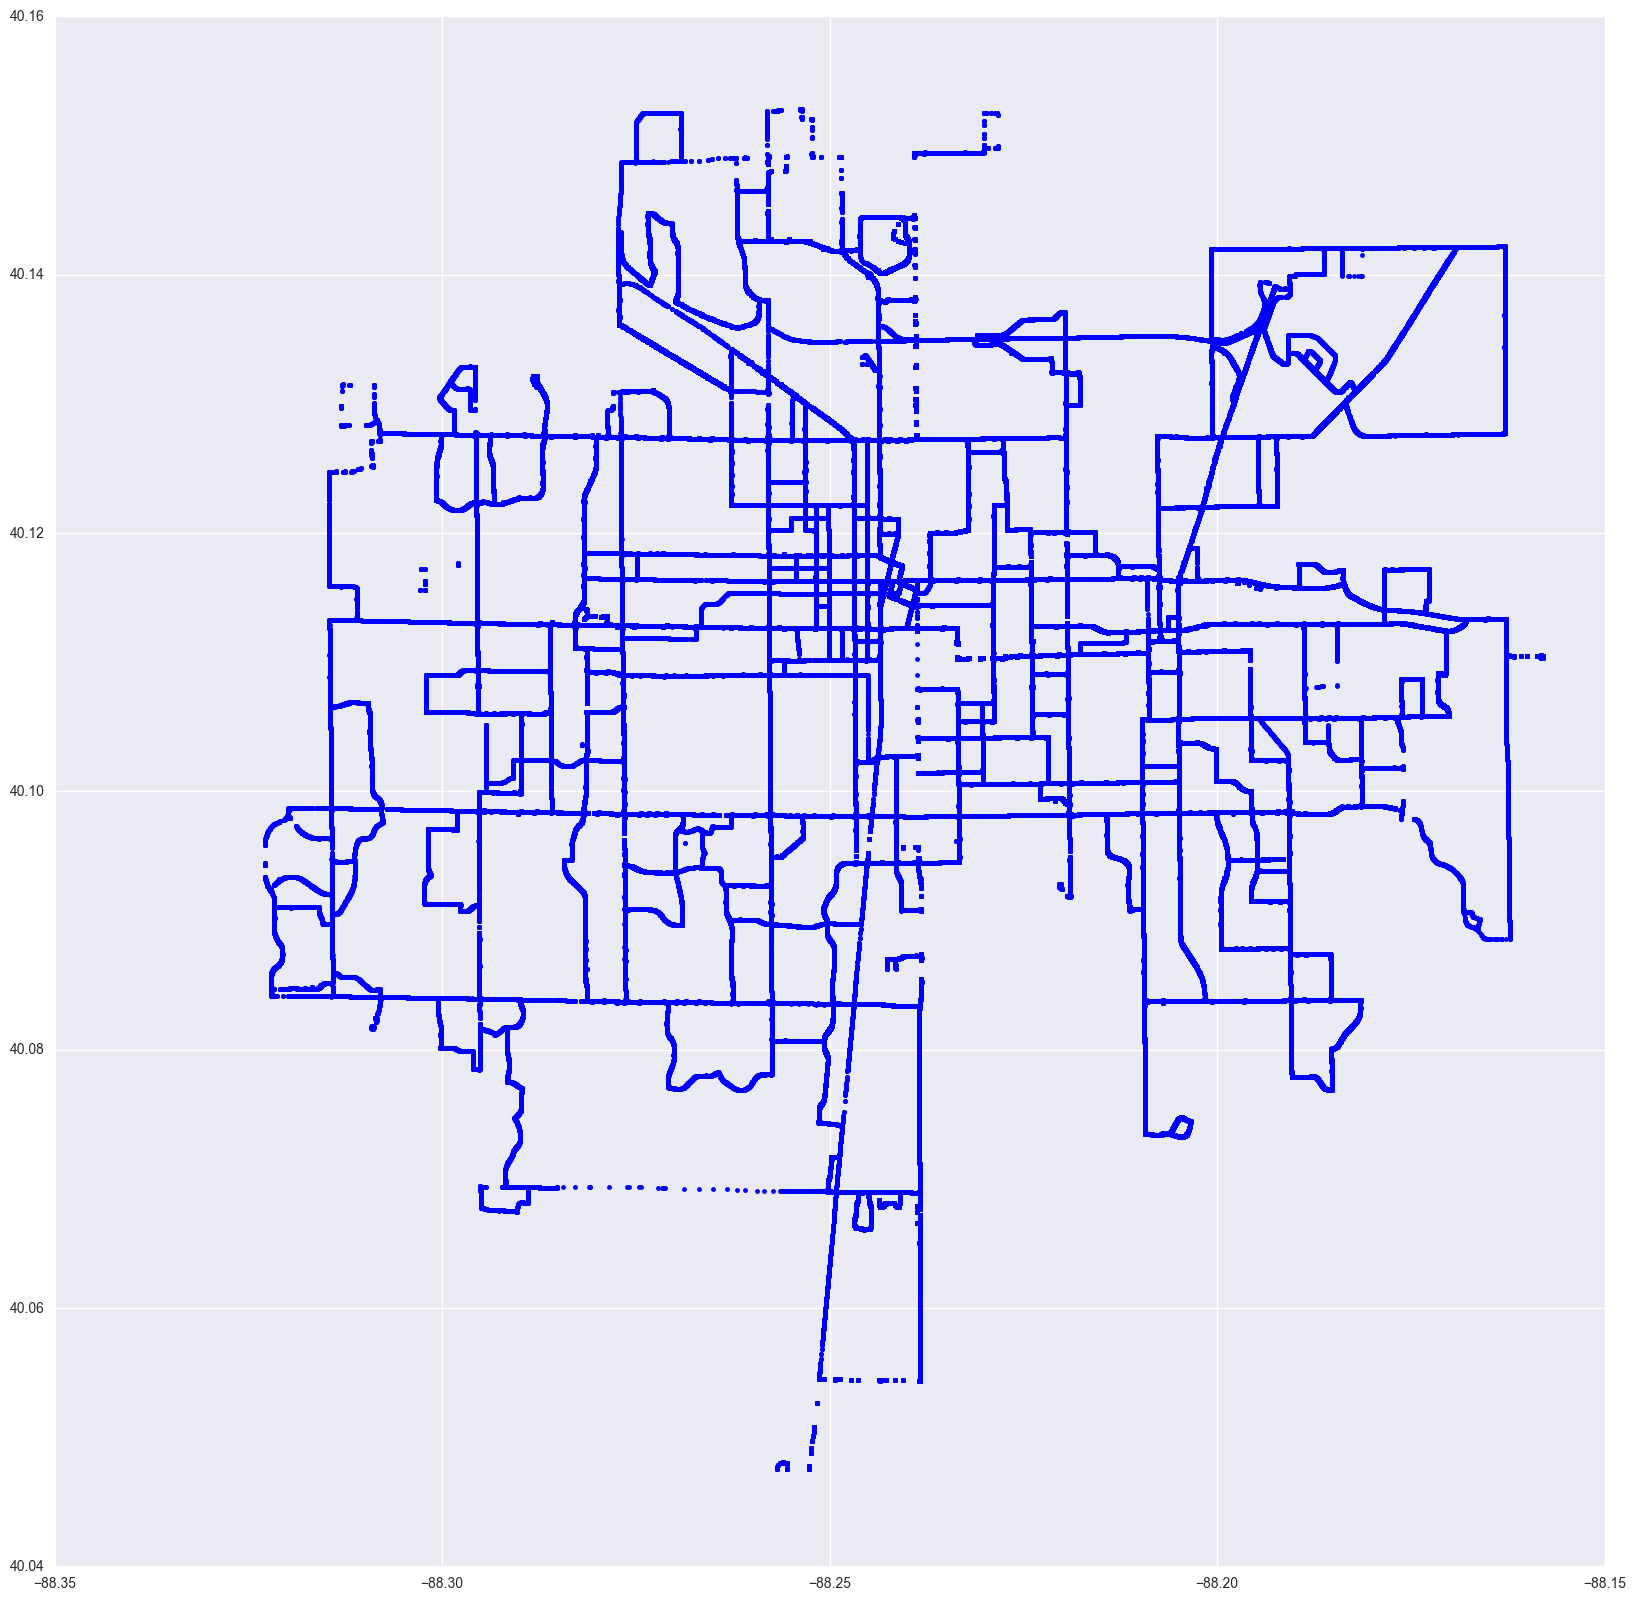

In [8]:
# all the rounts of CUMTD
plt.rcParams["figure.figsize"] = (20, 20)
plt.plot(data['shapes']['shape_pt_lon'],data['shapes']['shape_pt_lat'], '.b')

#### All Stops Operated by CUMTD

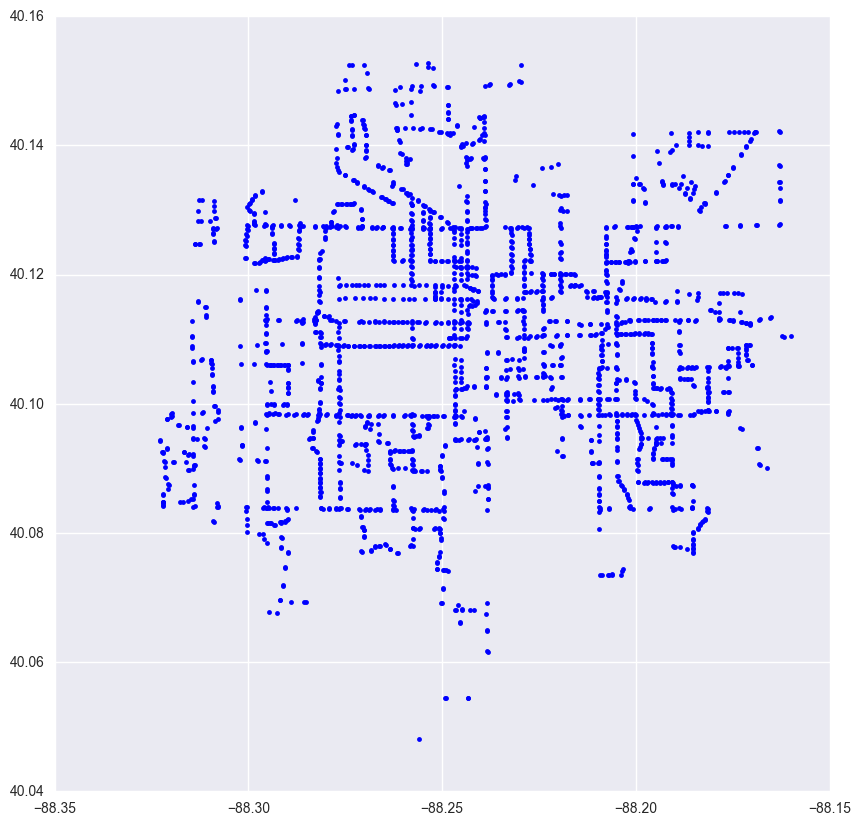

In [9]:
# all the stops of CUMTD
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(data['stops']['stop_lon'],data['stops']['stop_lat'], '.b')

#### Different CUMTD Routes

In [10]:
def map_by_route(route = 'TEAL'):
    selected1 = data['trips']['route_id'] == route
    shape_by_route = data['trips'][selected1]['shape_id']
    selected2 = data['shapes']['shape_id'].isin(shape_by_route)
    shape_selected = data['shapes'][selected2]
    selected3 = data['routes']['route_id'] == route
    color = '#' + data['routes'][selected3]['route_color'].values[0]
    plt.plot(shape_selected['shape_pt_lon'],shape_selected['shape_pt_lat'], 
             marker = '.', markersize = 1, alpha = 0.8, linewidth = 0, color = color)

<function __main__.map_by_route>

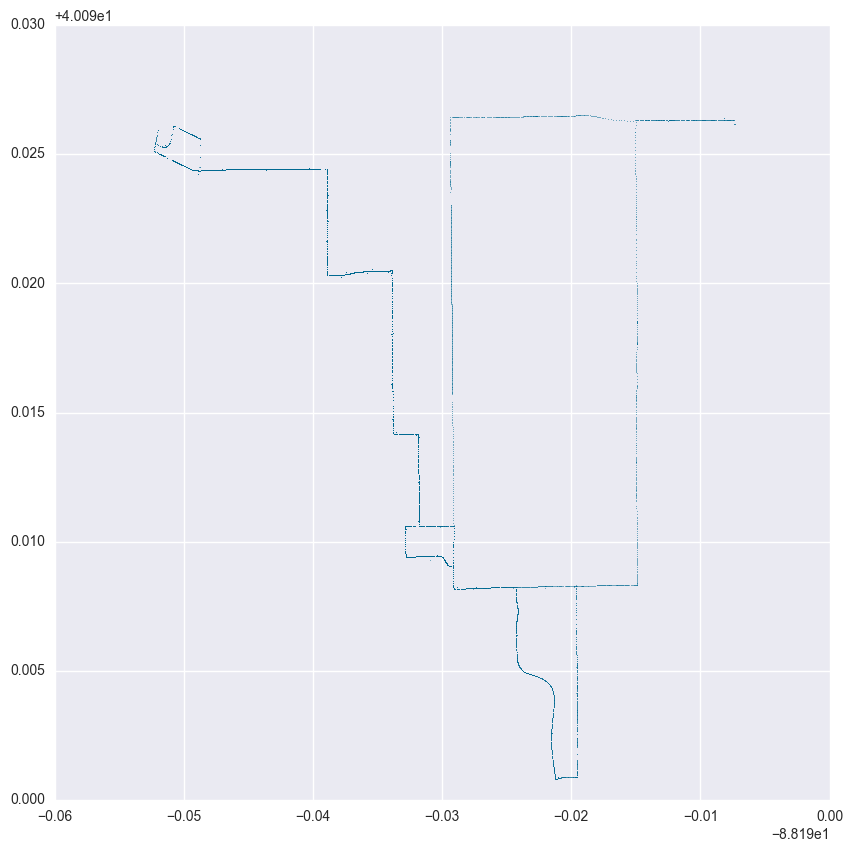

In [11]:
ipywidgets.interact(map_by_route, route = data['trips']['route_id'].unique().tolist())

#### Different Blocks Served by CUMTD

In [12]:
def stop_by_block(block):
    selected0 = data['trips']['block_id'] == block
    shape_by_block = data['trips'][selected0]['shape_id']
    selected1 = data['shapes']['shape_id'].isin(shape_by_block)
    shape_selected = data['shapes'][selected1]
    plt.plot(shape_selected['shape_pt_lon'],shape_selected['shape_pt_lat'], '.g')

<function __main__.stop_by_block>

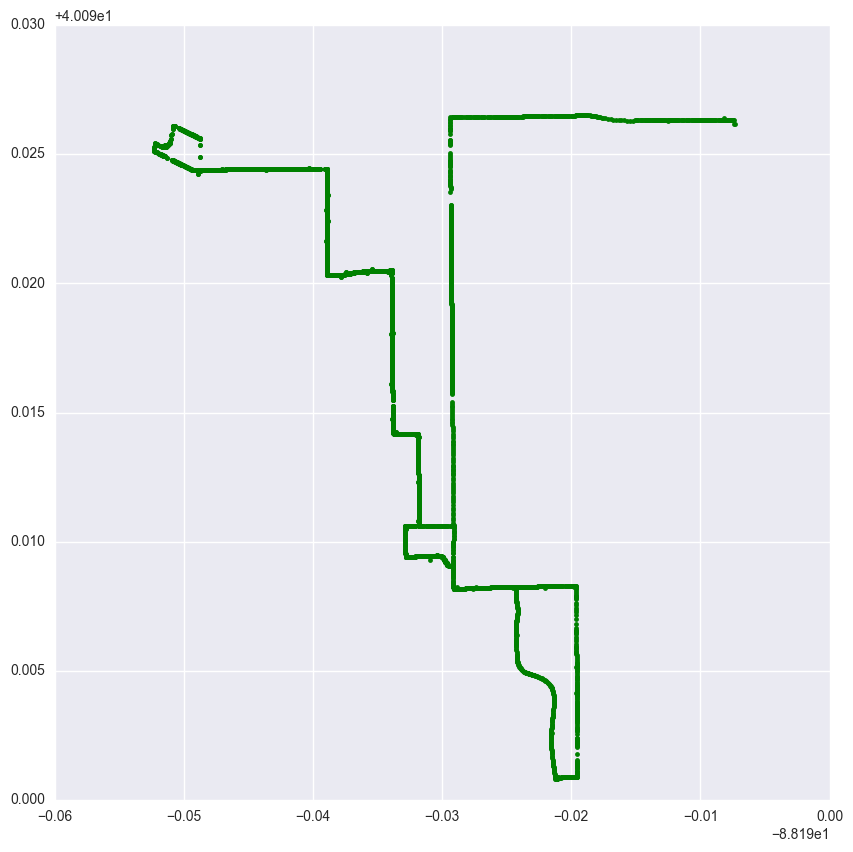

In [13]:
ipywidgets.interact(stop_by_block, block = data['trips']['block_id'].unique().tolist())

#### Exploration: Putting Relevant Shapes together to Construct a Route

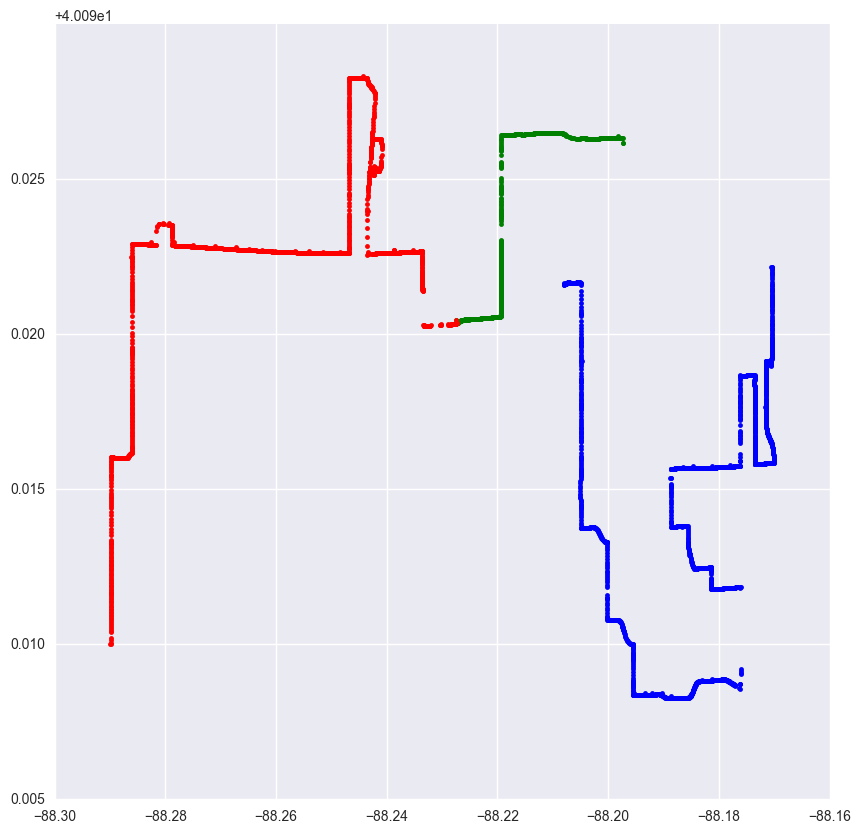

In [14]:
fig, ax = plt.subplots()
selected1 = data['shapes']['shape_id'].isin(['GN1PO'])
lat1 = data['shapes'][selected1]['shape_pt_lat']
lon1 = data['shapes'][selected1]['shape_pt_lon']
ax.plot(lon1,lat1,'.g')
selected2 = data['shapes']['shape_id'].isin(['5WIUE->'])
lat2 = data['shapes'][selected2]['shape_pt_lat']
lon2 = data['shapes'][selected2]['shape_pt_lon']
ax.plot(lon2,lat2,'.r')
selected3 = data['shapes']['shape_id'].isin(['GREEN 905'])
lat3 = data['shapes'][selected3]['shape_pt_lat']
lon3 = data['shapes'][selected3]['shape_pt_lon']
ax.plot(lon3,lat3,'.b')

## Question 1: Bus Travel Speed

In [15]:
#data['stop_times'].iloc[:100,0:5]

### Data Processing
---
#### Pre-processing Data relevant to Question 1.

####  1. Convert strings to datetime

In [16]:
data['stop_times']['arrival_time_cleaned'] = data['stop_times']['arrival_time'].copy()

In [17]:
data['stop_times']['arrival_time_cleaned'].size

242858

1.1. Replace ill-formated strings like '24:00:00', '25:09:00', or '29:00:02' to correct formats that could be recognized as datetime.

In [18]:
data['stop_times']['arrival_time_cleaned'] = data['stop_times']['arrival_time'].copy()
for hour in range(24,32):
    rgxs = re.compile(r'^{0}:'.format(hour))
    print("--- Dealing with {0}:00:00 ---".format(hour))
    time_cleaned = np.empty(len(data['stop_times']['arrival_time_cleaned']), dtype=object)
    for idx, t in enumerate(data['stop_times']['arrival_time_cleaned']):
        time_cleaned[idx] = rgxs.sub('0{0}:'.format(hour-24), t)
    data['stop_times']['arrival_time_cleaned'] = time_cleaned

print("--- Done ---")

--- Dealing with 24:00:00 ---
--- Dealing with 25:00:00 ---
--- Dealing with 26:00:00 ---
--- Dealing with 27:00:00 ---
--- Dealing with 28:00:00 ---
--- Dealing with 29:00:00 ---
--- Dealing with 30:00:00 ---
--- Dealing with 31:00:00 ---
--- Done ---


In [19]:
print("Test: ")

idx = 175226

print('Previous Obs.{0}:'.format(idx))
print(data['stop_times']['arrival_time'][idx])
print('Cleaned Obs.{0}:'.format(idx))
print(data['stop_times']['arrival_time_cleaned'][idx])

Test: 
Previous Obs.175226:
29:00:00
Cleaned Obs.175226:
05:00:00


1.2. Convert string to datetime.

In [20]:
fmt = "%H:%M:%S"

times = data['stop_times']['arrival_time_cleaned'].tolist()

ts = []

for idx, t in enumerate(times):
    t = datetime.strptime(t,fmt)
    t = t.replace(year=2017)
    ts.append(t)
    
data['stop_times']['times'] = ts

In [21]:
### A trick to deal with '00:00:00'

time_zero = ['23:59:59','00:00:00']
t_critical = []
for t in time_zero:
    t = datetime.strptime(t,fmt)
    t = t.replace(year=2017)
    t_critical.append(t)

####  2. Compute travel time between stops

2.1. Compute time differnece as arrival time of stop 2 - arrival time of stop 1.

In [22]:
### this block of codes may take a while to finish

time_between_stops = []
for idx, item in enumerate(data['stop_times']['times']):
        if idx == 0:
            time_between_stops.append(0)
        else:
            time1 = data['stop_times']['times'].iloc[idx]
            time2 = data['stop_times']['times'].iloc[idx - 1]
            time_between_stops.append((time.mktime(time1.timetuple()) - time.mktime(time2.timetuple())) / 60)

2.2. Fix some problems.

In [23]:
### this block of codes may take a while to finish

data['stop_times']['time_between'] = time_between_stops

for idx, item in enumerate(data['stop_times']['time_between']):
    if item < 0:
        
        time1 = data['stop_times']['times'].iloc[idx]
        time0 = data['stop_times']['times'].iloc[idx - 1]
        same_trip = data['stop_times']['trip_id'].iloc[idx] == data['stop_times']['trip_id'].iloc[idx - 1]
        if same_trip:
            time_zero_0 = t_critical[0]
            time_zero_1 = t_critical[1]
            time_corrected = (time.mktime(time_zero_0.timetuple()) - time.mktime(time0.timetuple())) / 60 + (time.mktime(time1.timetuple()) - time.mktime(time_zero_1.timetuple())) / 60
            data['stop_times']['time_between'].iloc[idx] = time_corrected
        else:
            data['stop_times']['time_between'].iloc[idx] = 0

/Users/abbypro/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2.3. Check if problems all fixed

In [24]:
wrong_time = []
for idx, item in enumerate(data['stop_times']['time_between']):
    if item < 0:
        
        time1 = data['stop_times']['arrival_time_cleaned'].iloc[idx]
        time0 = data['stop_times']['arrival_time_cleaned'].iloc[idx - 1]
        same_trip = data['stop_times']['trip_id'].iloc[idx] == data['stop_times']['trip_id'].iloc[idx - 1]
        if same_trip:
            print('{0}: arrival time: {1}'.format(idx - 1,time0))
            print('-'*6+' Same Trip: {}'.format(same_trip))
            print('{0}: arrival time: {1}'.format(idx,time1))
            print('{0}: arrival time (original): {1}'.format(idx,data['stop_times']['arrival_time'].iloc[idx]))
            print('{0}: converted time: {1}'.format(idx,data['stop_times']['times'].iloc[idx]))
            print('time between: {0}'.format(item))
            print('-'*30)
            wrong_time.append((idx, item))

In [25]:
print('Number of wrong time: {}'.format(len(wrong_time)))

Number of wrong time: 0


### Building Functions
---
#### Building some functions to facilitate data visualization.

In [26]:
def get_stop_latlon(stop):
    match = data['stops']['stop_id'] == stop
    stop_lat = data['stops'][match]['stop_lat'].values[0]
    stop_lon = data['stops'][match]['stop_lon'].values[0]
    return stop_lon, stop_lat

In [27]:
def get_stop_name(stop):
    match = data['stops']['stop_id'] == stop
    stop_name = data['stops'][match]['stop_name'].values[0]
    return stop_name

In [28]:
print(get_stop_name('ODSS:1'))

Orchard Downs South Shelter


In [29]:
print(get_stop_latlon('ODSS:1'))

(-88.211043329999995, 40.09090667000001)


In [30]:
def get_stops_positions(stoplist, use_stop_name = False):
    
    stop_pos = {}
    
    for stop in stoplist:
        if use_stop_name:
            tag = get_stop_name(stop)
        else:
            tag = stop
            
        stop_lon, stop_lat = get_stop_latlon(stop)
        stop_pos[tag] = stop_lon, stop_lat
        
    return stop_pos

In [31]:
def get_route_color(route):
    selected = data['routes']['route_id'] == route
    color = '#' + data['routes'][selected]['route_color'].values[0]
    return color

In [32]:
def get_trips_on_route(route):
    selected = data['trips']['route_id'] == route
    trips = data['trips'][selected]['trip_id']
    return trips

In [33]:
def get_directions_on_route(route):
    selected = data['trips']['route_id'] == route
    directions = data['trips'][selected]['direction_id']
    return directions

In [34]:
def get_directed_trips(route, direction = 1):
    trips_2 = get_trips_on_route(route)
    direct = get_directions_on_route(route)
    trips = trips_2[direct == direction]
    return trips

In [35]:
def get_stops_on_route(route, direction = 1):
    trips = get_directed_trips(route, direction = direction)
    stoplist = []
    for trip in trips:
        selected =  data['stop_times']['trip_id'] == trip
        stoplist.extend(data['stop_times'][selected]['stop_id'])
    return stoplist

In [50]:
def get_shape_of_route(route, direction = 1):
    trips = get_directed_trips(route)
    selected = data['trips']['trip_id'].isin(trips)
    shape_by_route = data['trips'][selected]['shape_id'].unique()
    return shape_by_route

In [37]:
def get_stop_pairs():
    stop_network = {}
    stops_by_trip = data['stop_times'].groupby('trip_id')
    for trip_id, trip in stops_by_trip:
        stop_network[trip_id] = []
        print('Dealing with trip {} ...'.format(trip_id))
        stop_ids = trip['stop_id']
        travel_times = trip['time_between']
        #travel_times = time_travel[trip_id]
        for idx, item in enumerate(stop_ids):
            if idx != 0:
                stop_network[trip_id].append(((stop_ids.iloc[idx-1],stop_ids.iloc[idx]),travel_times.iloc[idx]))
    
    return stop_network

#### Get all pairs of connected stop

In [38]:
# This may take a few seconds to finish

stop_network = get_stop_pairs()

Dealing with trip 1GN500__GN1_MF ...
Dealing with trip 1GN507__GN1_MF ...
Dealing with trip 1GN508__GN1_MF ...
Dealing with trip 1GN509__GN1_MF ...
Dealing with trip 1GN510__GN1_MF ...
Dealing with trip 1GN511__GN1_MF ...
Dealing with trip 1GN512__GN1_MF ...
Dealing with trip 1GN513__GN1_MF ...
Dealing with trip 1GN514__GN1_MF ...
Dealing with trip 1GN515__GN1_MF ...
Dealing with trip 1GN516__GN1_MF ...
Dealing with trip 1GN517__GN1_MF ...
Dealing with trip 1GNX100__Y4_MF ...
Dealing with trip 1GNX102__GNX1_NOSCHMF ...
Dealing with trip 1GNX102__GNX1_SCHMF ...
Dealing with trip 20RED001__R1SA ...
Dealing with trip 20RED002__R1SA ...
Dealing with trip 20RED003__R1SA ...
Dealing with trip 20RED004__R1SA ...
Dealing with trip 20RED005__R1SA ...
Dealing with trip 20RED006__R1SA ...
Dealing with trip 20RED007__R1SA ...
Dealing with trip 20RED008__R1SA ...
Dealing with trip 20RED009__R1SA ...
Dealing with trip 20RED010__R1SA ...
Dealing with trip 20RED011__R1SA ...
Dealing with trip 20RED012

In [39]:
def select_pairs_by_route(route, direction = 1):
    trips = get_directed_trips(route, direction = direction)
    #stop_network = get_stop_pairs()
    pair_in_route = []
    for trip in trips:
        pair_in_route.extend(stop_network[trip])
        
    return pair_in_route

In [40]:
print('Test:')
route = 'TEAL'
print('Total trips on route {0}: {1}'.format(route,len(get_trips_on_route(route))))
print('Total stops on route {0}: {1}'.format(route,len(get_stops_on_route(route))))
print('Total pairs on route {0}: {1}'.format(route,len(select_pairs_by_route(route))))
pairs = select_pairs_by_route(route)
print('First pair ((Stop1, Stop2), Travel Time): {}'.format(pairs[0]))

Test:
Total trips on route TEAL: 238
Total stops on route TEAL: 2460
Total pairs on route TEAL: 2336
First pair ((Stop1, Stop2), Travel Time): (('DEPOT:1', 'PAR:2'), 10.0)


### Data Visualization: Different Routes and Stops on Routes (edges indicating travel time)
----
The width of the edge connecting two stops indicate how long it takes from one stop to the next.

In [41]:
def create_graph_by_route(route = 'GREEN', direction = 1):
    
    # initiate a graph
    g = nx.Graph()

    # get stop pairs
    pairs = select_pairs_by_route(route, direction = direction)

    # add edges
    for (stop1, stop2), weight in pairs:
        g.add_edge(stop1, stop2, weight=weight)

    return g

In [42]:
def draw_graph_by_route(g, route = 'GREEN', direction = 1):
    
    # some image formatting
    fig, ax = plt.subplots(figsize=(10, 10))
    #sns.despine(ax=ax, top = True, bottom = True, left = True, right = True)
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    
    # draw the shape of the route
    map_by_route(route) 
    
    # the positions of all nodes
    stoplist = get_stops_on_route(route, direction = direction)
    pos = get_stops_positions(stoplist)
    
    # set the color of the nodes and edges
    clr = get_route_color(route)

    # draw the nodes
    nx.draw_networkx_nodes(g, pos, with_labels=True,
                       node_color=clr, node_size = 10,
                       alpha = 1)
    
    # draw the edges
    edges = []
    weights = []

    for n1, n2, dct in g.edges(data=True):
        edges.append((n1, n2))
        weights.append(dct['weight']*2)
    
    # select edges 
    edges_selected = []
    for idx, weight in enumerate(weights):
        if weight < 5:
            edges_selected.append(edges[idx])

    nx.draw_networkx_edges(g, pos, 
                       width = weights, edgelist = edges_selected, 
                       edge_color = [clr]*len(edges_selected),
                       alpha = 0.6)
    
    # add labels
    #nx.draw_networkx_labels(g, pos, alpha = 1.0, font = 0.1)
    
    return ax

In [43]:
def get_route_graph(route = 'GREEN', direction = 1):
    g = create_graph_by_route(route = route, direction = direction)
    route_ax = draw_graph_by_route(g, route = route, direction = direction)
    return route_ax

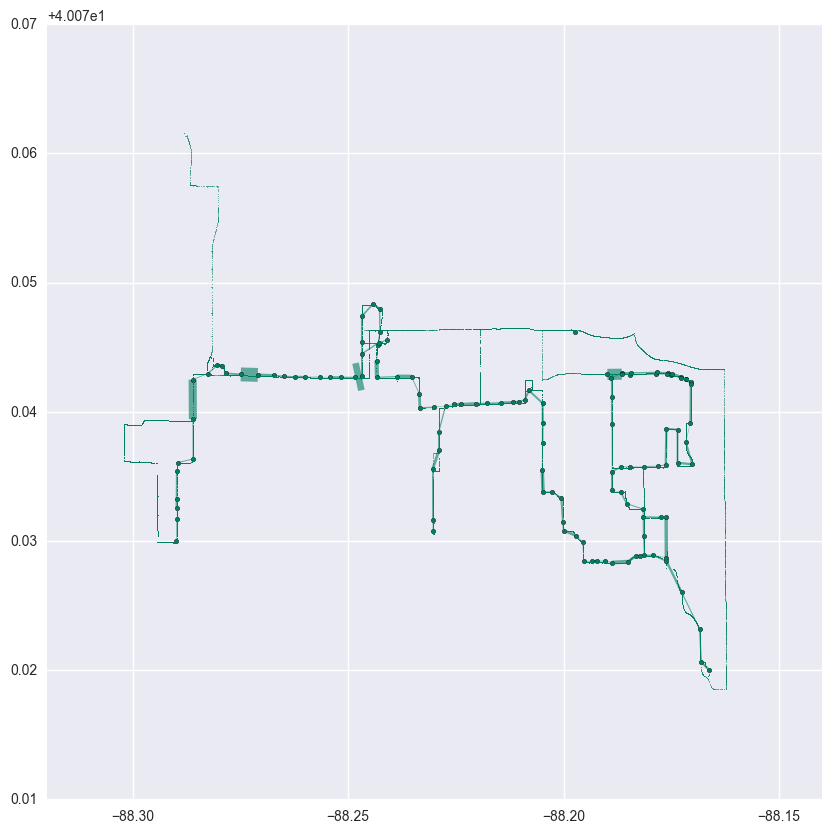

In [44]:
ipywidgets.interact(get_route_graph, route = data['trips']['route_id'].unique().tolist(), direction = [0,1])

#### Use Plotly to Create a Fancier Network Graph (in progress)

In [94]:
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import colorlover as cl

# plotly credential
plotly.tools.set_credentials_file(username='lzeng6', api_key='sET35IN6zBEbv5lZaT9M')

In [126]:
# create network graph
route = 'ILLINI'
direction = 1
clr = get_route_color(route)
g = create_graph_by_route(route = route, direction = direction)
stoplist = get_stops_on_route(route, direction = direction)

In [159]:
# the positions of all nodes
pos = get_stops_positions(stoplist)

# add edges
edge_trace = Scatter(
    x=[],
    y=[],
    hoverinfo='none',
    mode='lines',
    line=dict(
        color=clr,
        width=0.5,
        ))

weights = {}
for n1, n2, dct in g.edges(data=True):
    x0, y0 = pos[n1]
    x1, y1 = pos[n2]
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]
    weights[n2] = dct['weight'] 
    
# add nodes
node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    #textposition='middle right',
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        color=clr,
        size=[],
        line=dict(width=1)))

for node in g.nodes():
    x, y = pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    if weights.get(node,0) != 0:
        node_info = '{0:5.2f} mins'.format(weights.get(node,0))
        node_trace['text'].append(node_info)

for node, adjacencies in enumerate(g.adjacency_list()):
    node_trace['marker']['size'].append(len(adjacencies)*5)
    
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>CUMTD Stops Network: Route {0}'.format(route),
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')

PlotlyRequestError: Hey there! You've hit one of our API request limits. 

To get unlimited API calls(10,000/day), please upgrade to a paid plan. 

UPGRADE HERE: https://goo.gl/i7glmM 

Thanks for using Plotly! Happy Plotting!

### Data Visualization: Descriptive Statistics
---
Get descriptive statistics and data visualization on the statistics

In [48]:
shape_by_id = data['shapes'].groupby('shape_id')
dist_by_shape = shape_by_id['shape_dist_traveled'].max()

In [54]:
def get_shapes_of_trip(trip):
    selected = data['trips']['trip_id'] == trip
    shapes_of_trip = data['trips'][selected]['shape_id'].unique()
    return shapes_of_trip

In [56]:
def get_travel_time_by_trip(trip):
    trip_time = 0
    for (stop1,stop2), time in stop_network[trip]:
        trip_time += time
    return trip_time

In [71]:
def get_travel_dist_by_trip(trip):
    trip_shapes = get_shapes_of_trip(trip)
    trip_dist = 0
    for shape in trip_shapes:
        trip_dist += dist_by_shape[shape]
    return trip_dist

In [76]:
def get_speed(dist,time):
    if time != 0:
        speed = dist/time
    else:
        speed = 'Not Applicable'
    return speed

In [82]:
def average_speed_by_route(route, direction = 1):
    
    # get all the trips on this route
    trips = get_directed_trips(route = route, direction = direction)
    
    # calculate average route speed over all the trips on this route
    if len(trips) != 0:
        trip_times = []
        trip_dists = []
        trip_speeds = []
        
        for trip in trips:
            trip_time = get_travel_time_by_trip(trip)
            if trip_time == 0:
                continue
            else:
                trip_dist = get_travel_dist_by_trip(trip)
                trip_times.append(trip_time)
                trip_dists.append(trip_dist)
                trip_speeds.append(get_speed(trip_dist, trip_time))
        
        route_time = sum(trip_times)/len(trip_times)
        route_dist = sum(trip_dists)/len(trip_dists)
        route_speed = sum(trip_speeds)/len(trip_speeds)
        
    else:
        route_dist = 0
        route_time = 0
        route_speed = 'Not Applicable'
    
    return route_dist,route_time,route_speed

#### 1. Summary: Average speed by route

In [83]:
#for route in data['routes']['route_id'].unique().tolist():
#    route_dist,route_time,route_speed = average_speed_by_route(route = route)
#    print('Route {0}'.format(route))
#    if route_time != 0:
#        print('Avg Speed: {0:5.3f} m/min'.format(route_speed))
#    if route_time == 0:
#        print('Avg Speed: {0}'.format(route_speed))
#    print('Total Time: {0:5.3f} mins'.format(route_time))
#    print('Total Dist: {0:5.3f} ms'.format(route_dist))
#    print('-'*30)

Route GOLD ALT
Avg Speed: 733.249 m/min
Total Time: 13.750 mins
Total Dist: 8369.620 ms
------------------------------
Route RUBY SATURDAY
Avg Speed: 496.143 m/min
Total Time: 28.231 mins
Total Dist: 14000.955 ms
------------------------------
Route SILVER LIMITED SATURDAY
Avg Speed: 341.991 m/min
Total Time: 9.800 mins
Total Dist: 3322.214 ms
------------------------------
Route BROWN ALT PM
Avg Speed: 380.505 m/min
Total Time: 25.250 mins
Total Dist: 8743.883 ms
------------------------------
Route YELLOW LATE NIGHT SUNDAY
Avg Speed: 394.518 m/min
Total Time: 28.117 mins
Total Dist: 11157.072 ms
------------------------------
Route GREEN EVENING SATURDAY
Avg Speed: 388.515 m/min
Total Time: 46.813 mins
Total Dist: 18580.209 ms
------------------------------
Route GREY ALT
Avg Speed: 306.558 m/min
Total Time: 23.989 mins
Total Dist: 6846.862 ms
------------------------------
Route TEAL LATE NIGHT SUNDAY
Avg Speed: 298.475 m/min
Total Time: 18.999 mins
Total Dist: 5670.837 ms
---------

#### 2. Bar chart: Average speed by route

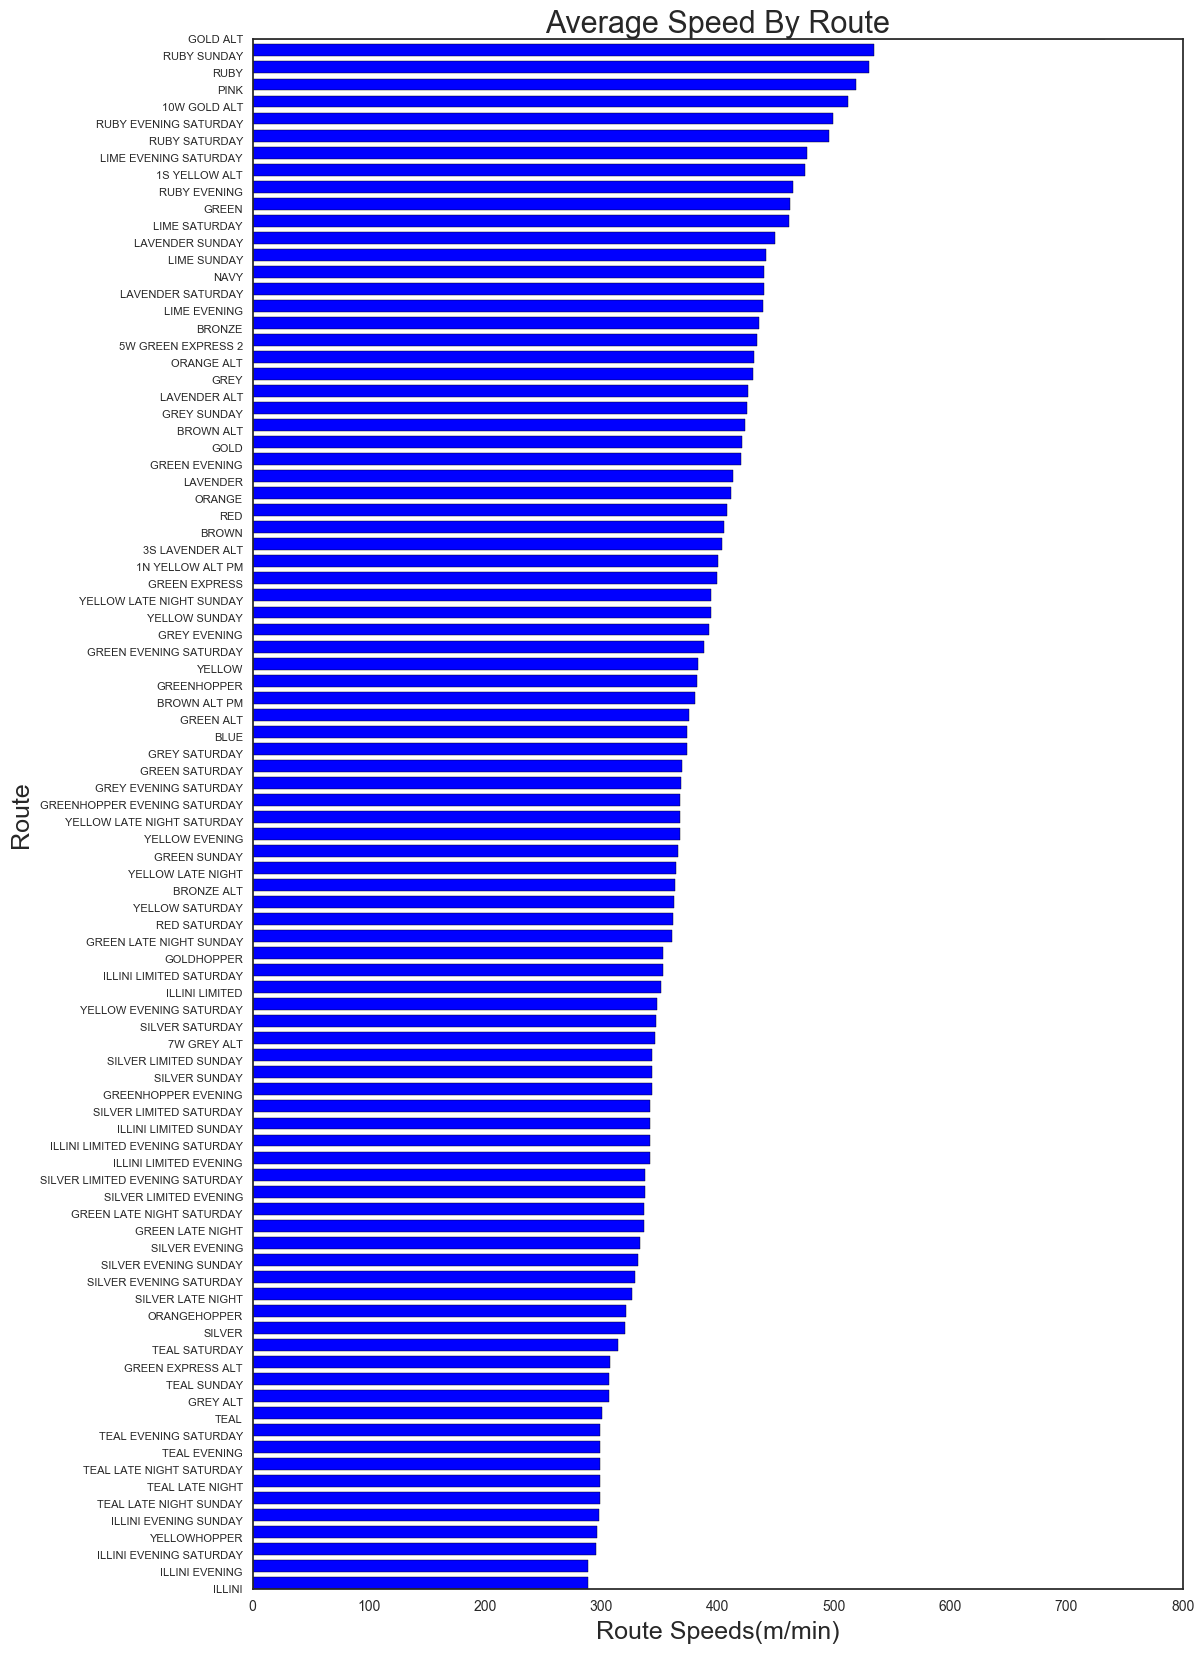

In [333]:
route_speeds = []
routes = []
route_records = {}
for route in data['routes']['route_id'].unique().tolist():
    route_dist,route_time,route_speed = average_speed_by_route(route = route)
    if route_time != 0:
        route_records[route] = route_speed
        
route_list = sorted(route_records.items(), key=lambda d:d[1])    

for item in route_list:
    route_speeds.append(item[1])
    routes.append(item[0])

x = route_speeds
N = len(x)
y = range(N)
plt.figure(figsize=(12, 20))
plt.ylim(0,1)
plt.barh(y, x, color="blue", height = 0.7)
plt.yticks(y, routes, rotation='horizontal', size = 8)
plt.xlabel('Route Speeds(m/min)', fontsize = 18)
plt.ylabel('Route', fontsize = 18)
plt.title('Average Speed By Route', fontsize = 22)
plt.show()

#### Different Types of Routes

In [300]:
match_weekend = re.compile(r'(SATURDAY|SUNDAY)')
match_eve = re.compile(r'EVENING')
match_alt = re.compile(r'ALT')
match_express = re.compile(r'EXPRESS')

weekend = []
eve = []
alt = []
regular = []
express = []
all_routes = get_routes_speed_by_type(routes = data['routes']['route_id'].unique().tolist())[0]

for route in all_routes:
    for word in route.split():
        if re.match(match_weekend,word):
            weekend.append(route)
        elif re.match(match_eve,word):
            eve.append(route)
        elif re.match(match_alt,word):
            alt.append(route)
        elif re.match(match_express,word):
            express.append(route)

for route in all_routes:
    if route not in set(weekend+eve+alt+express):
        regular.append(route)

In [301]:
fmt_str = 'Routes in {0}: {1}'
print(fmt_str.format('Weekend', len(weekend)))
print('-'*30)
print(fmt_str.format('Evening', len(eve)))
print('-'*30)
print(fmt_str.format('Alt', len(alt)))
print('-'*30)
print(fmt_str.format('Express', len(express)))
print('-'*30)
print(fmt_str.format('Regular', len(regular)))
print('-'*30)
print(fmt_str.format('All', len(all_routes)))
print('-'*30)

Routes in Weekend: 40
------------------------------
Routes in Evening: 24
------------------------------
Routes in Alt: 14
------------------------------
Routes in Express: 3
------------------------------
Routes in Regular: 25
------------------------------
Routes in All: 92
------------------------------


In [302]:
def get_routes_speed_by_type(routes):
    route_speeds = []
    routes_selected = []
    route_records = {}
    for route in routes:
        route_dist,route_time,route_speed = average_speed_by_route(route = route)
        if route_time != 0:
            route_records[route] = route_speed
        
    route_list = sorted(route_records.items(), key=lambda d:d[1])    

    for item in route_list:
        route_speeds.append(item[1])
        routes_selected.append(item[0])
        
    return routes_selected, route_speeds

In [328]:
def bar_chart_by_type(routes, title = 'All Routes', ax = ax, k = 1):
    
    routes_selected, route_speeds = get_routes_speed_by_type(routes)
    
    sns.set_style("white")

    clrs = [get_route_color(r) for r in routes_selected]
    mean_speed = sum(route_speeds)/len(route_speeds)

    x = route_speeds
    N = len(x)
    y = list(range(N))
    y_ticks = [i+0.5 for i in y]
    
    ax.set_ylim(0,1)
    ax.barh(y, x, color = clrs, height = 0.7, alpha = 0.8)
    ax.axvline(x = mean_speed, color='black', linestyle='--', lw=1.5, alpha = 0.8)
    ax.text(mean_speed + 10*k, 10*k, 'mean speed: \n{0:5.2f} m/min'.format(mean_speed), fontsize = 18*k)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(routes_selected)
    ax.tick_params(labelsize = 10*k)
    ax.set_title('Average Speed By Route: {}'.format(title), fontsize = 22*k)
    ax.set_xlabel('Route Speed (m/min)', fontsize = 18*k)
    ax.set_ylabel('Route', fontsize = 18*k)

    sns.despine(trim = True, offset = 0)

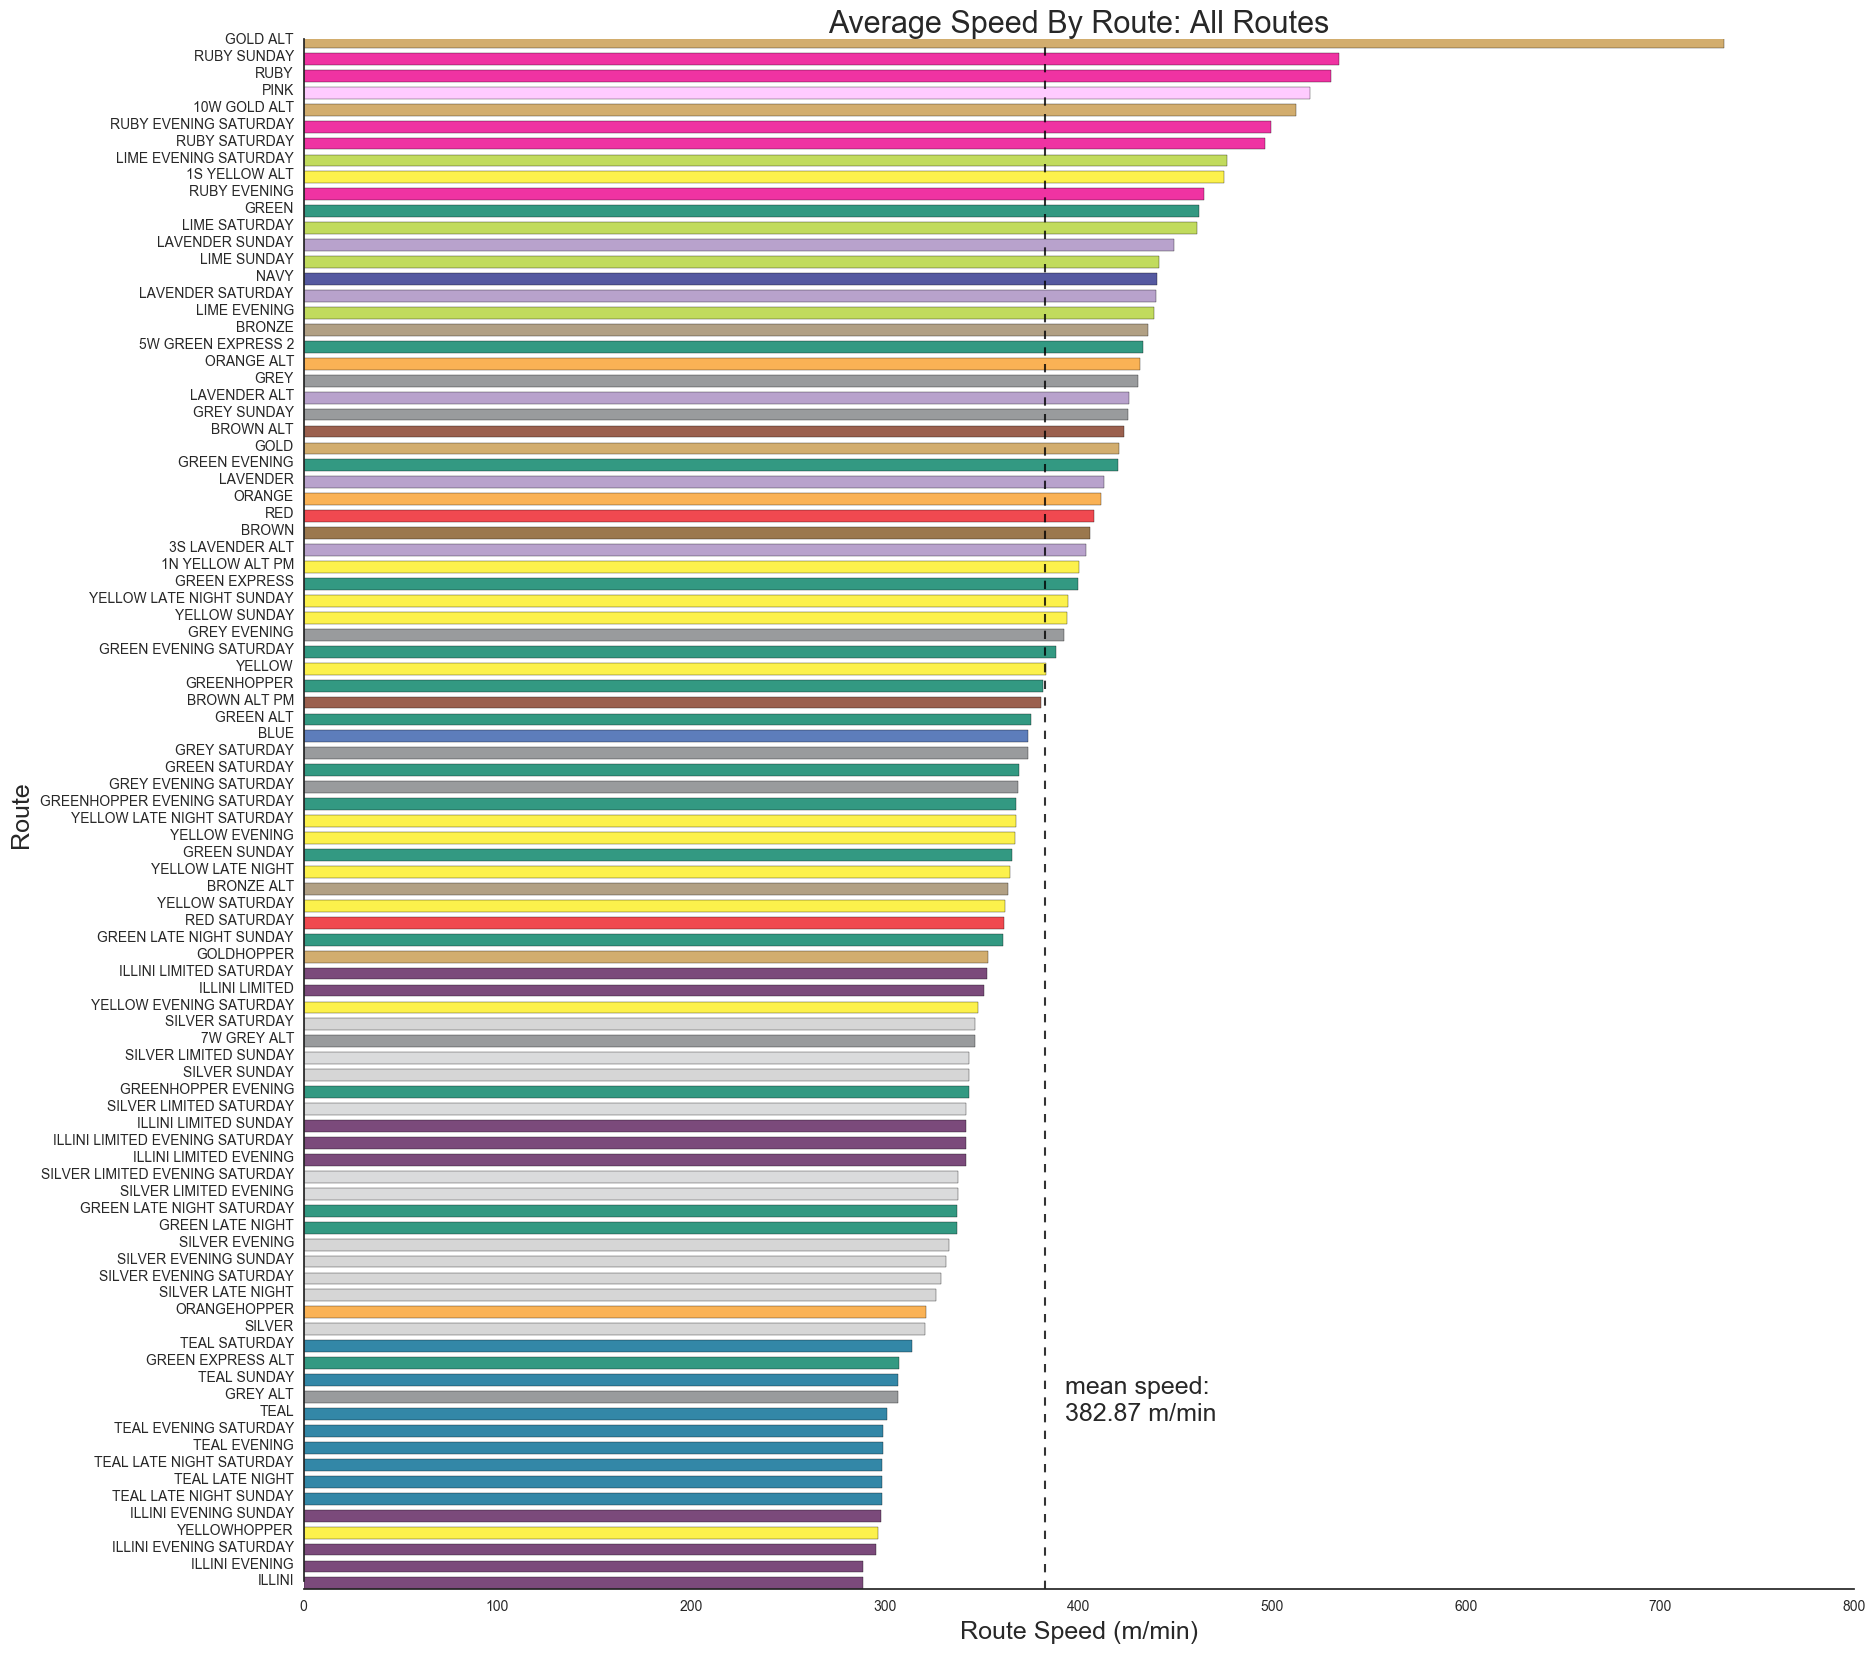

In [329]:
fig, ax = plt.subplots(figsize = (20,20))
ax.set_title('Average Speed By Route: {}'.format('All Routes'), fontsize = 22)
bar_chart_by_type(routes = data['routes']['route_id'].unique().tolist(), ax = ax)

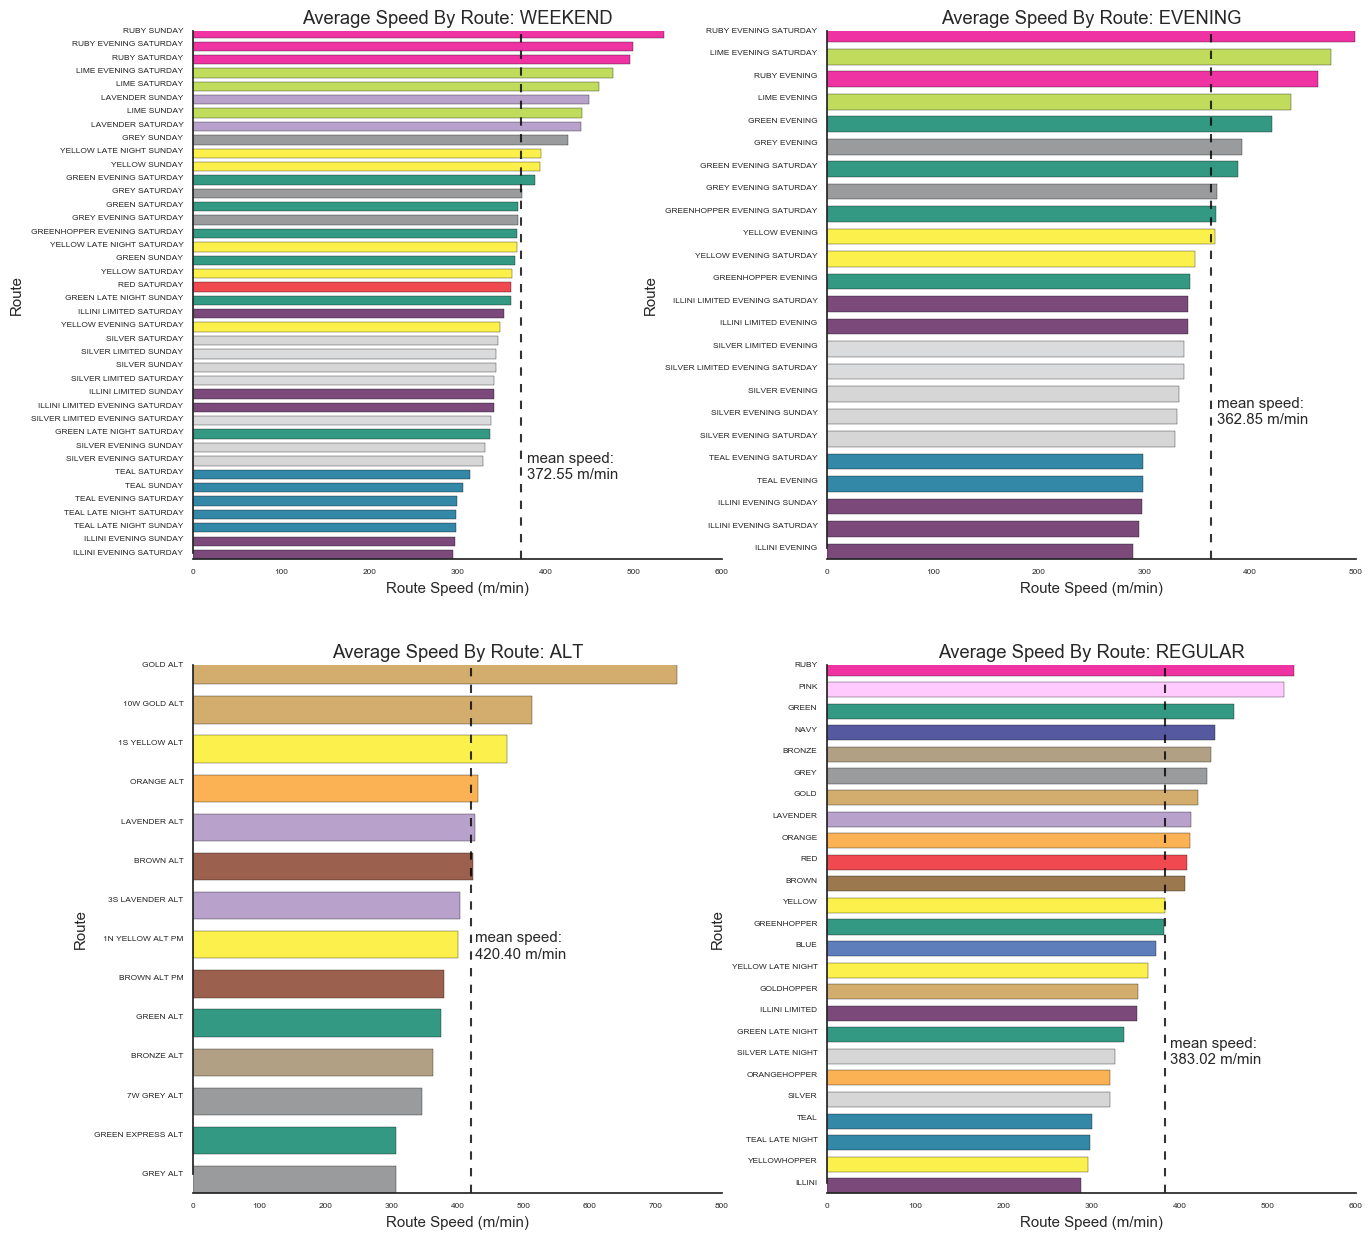

In [332]:
# make the main figure
fig = plt.figure(1)
plt.suptitle("Average Speeds of Different Types of Routes", fontsize = 28)
plt.rcParams["figure.figsize"] = (40, 40)

# make the subplots
k = 0.6
plt.figure(figsize=(15, 15))
ax1 = plt.subplot(2,2,1)
bar_chart_by_type(routes = weekend, title = 'WEEKEND', ax = ax1, k = k)
ax2 = plt.subplot(2,2,2)
bar_chart_by_type(routes = eve, title = 'EVENING', ax = ax2, k = k)
ax3 = plt.subplot(2,2,3)
bar_chart_by_type(routes = alt, title = 'ALT', ax = ax3, k = k)
ax4 = plt.subplot(2,2,4)
bar_chart_by_type(routes = regular, title = 'REGULAR', ax = ax4, k = k)